# 영화리뷰 텍스트 감성분석하기 



# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### install mecab

In [2]:
pip install konlpy

In [3]:
!pip install mecab-python3

In [4]:
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcurl4 libcurl4-openssl-dev
Suggested packages:
  libcurl4-doc libidn11-dev libkrb5-dev libldap2-dev librtmp-dev
The following packages will be upgraded:
  curl libcurl4 libcurl4-openssl-dev
3 upgraded, 0 newly installed, 0 to remove and 101 not upgraded.
Need to get 679 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcurl4-openssl-dev amd64 7.58.0-2ubuntu3.14 [301 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 curl amd64 7.58.0-2ubuntu3.14 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcurl4 amd64 7.58.0-2ubuntu3.14 [219 kB]
Fetched 679 kB in 1s (560 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend 

In [5]:
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git

fatal: destination path 'mecab-python-0.996' already exists and is not an empty directory.


In [6]:
cd /mecab-python-0.996

[Errno 2] No such file or directory: '/mecab-python-0.996'
/content


In [7]:
!python setup.py build
!python setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [8]:
!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

### 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 제공되었지만 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있음

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [9]:
from konlpy.tag import Okt
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.3f}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  41
전체 문장의 0.934%가 maxlen 설정값 이내에 포함됩니다. 


## 4) 모델 구성 및 validation set 구성 

In [13]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [14]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 5) 모델훈련 개시 & 6) Loss, Accuracy 그래프 시각화

### RNN

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_rnn.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 10ms/step - loss: 0.4882 - accuracy: 0.7906 - val_loss: 0.3640 - val_accuracy: 0.8444
Epoch 2/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3483 - accuracy: 0.8507 - val_loss: 0.3380 - val_accuracy: 0.8526
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3272 - accuracy: 0.8610 - val_loss: 0.3356 - val_accuracy: 0.8559
Epoch 4/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3162 - accuracy: 0.8656 - val_loss: 0.3314 - val_accuracy: 0.8547
Epoch 5/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3076 - accuracy: 0.8693 - val_loss: 0.3278 - val_accuracy: 0.8550
Epoch 6/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2988 - accuracy: 0.8726 - val_loss: 0.3278 - val_accuracy: 0.8574
Epoch 7/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2905 - accuracy: 0.8765 - val_loss: 0.3286 - val_accuracy: 0.8597
Epoch

In [21]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)
print(results_rnn, '\n')

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 3s - loss: 0.3358 - accuracy: 0.8560
[0.3358374834060669, 0.8560327291488647] 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


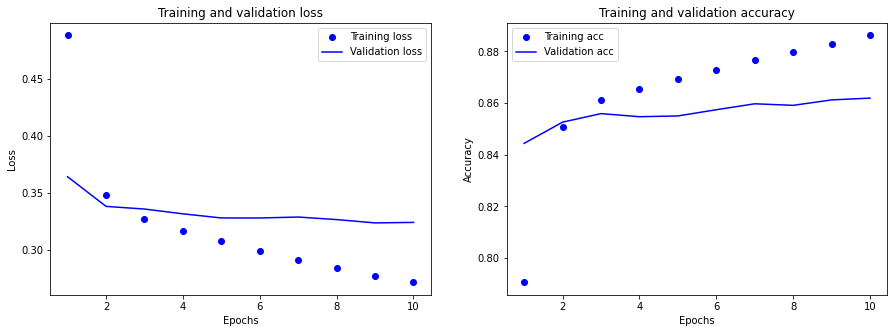

In [22]:
import matplotlib.pyplot as plt

acc = history_dict_rnn['accuracy']
val_acc = history_dict_rnn['val_accuracy']
loss = history_dict_rnn['loss']
val_loss = history_dict_rnn['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN

In [23]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [72]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2241 - accuracy: 0.9086 - val_loss: 0.3456 - val_accuracy: 0.8604
Epoch 2/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2208 - accuracy: 0.9101 - val_loss: 0.3521 - val_accuracy: 0.8616
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2183 - accuracy: 0.9114 - val_loss: 0.3579 - val_accuracy: 0.8617
Epoch 4/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2155 - accuracy: 0.9130 - val_loss: 0.3589 - val_accuracy: 0.8606
Epoch 5/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2129 - accuracy: 0.9145 - val_loss: 0.3538 - val_accuracy: 0.8585
Epoch 6/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2101 - accuracy: 0.9156 - val_loss: 0.3520 - val_accuracy: 0.8611
Epoch 7/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2080 - accuracy: 0.9165 - val_loss: 0.3541 - val_accuracy: 0.8606
Epoch 

In [73]:
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results_cnn, '\n')

history_dict_cnn = history_cnn.history
print(history_dict_cnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 3s - loss: 0.6931 - accuracy: 0.4989
[0.6931074261665344, 0.49893200397491455] 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


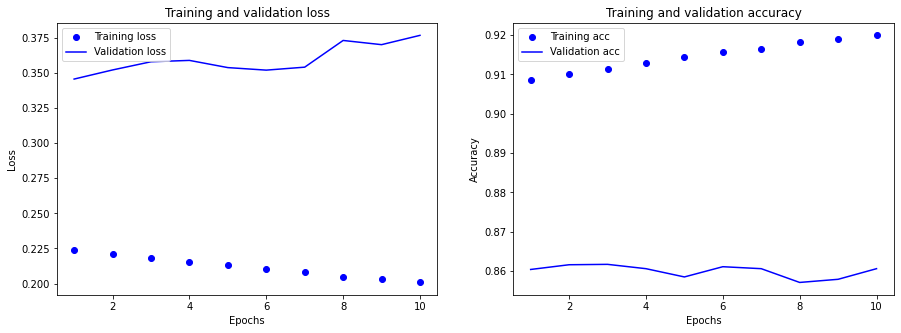

In [74]:
import matplotlib.pyplot as plt

acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D

In [27]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = keras.Sequential()
model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [28]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_gmp.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 6ms/step - loss: 0.5850 - accuracy: 0.7549 - val_loss: 0.4554 - val_accuracy: 0.8052
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.4001 - accuracy: 0.8272 - val_loss: 0.3704 - val_accuracy: 0.8300
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3540 - accuracy: 0.8461 - val_loss: 0.3540 - val_accuracy: 0.8391
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3352 - accuracy: 0.8564 - val_loss: 0.3475 - val_accuracy: 0.8441
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3231 - accuracy: 0.8631 - val_loss: 0.3447 - val_accuracy: 0.8463
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8673 - val_loss: 0.3439 - val_accuracy: 0.8466
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3080 - accuracy: 0.8712 - val_loss: 0.3447 - val_accuracy: 0.8484
Epoch 

In [29]:
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)
print(results_gmp, '\n')

history_dict_gmp = history_gmp.history
print(history_dict_gmp.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 2s - loss: 0.3600 - accuracy: 0.8455
[0.3600058853626251, 0.8454543352127075] 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


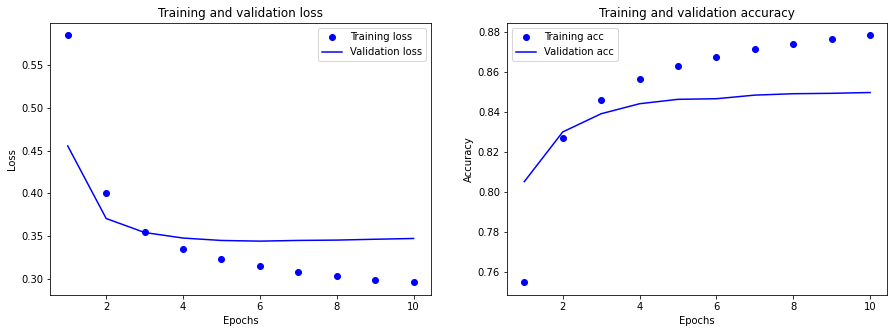

In [31]:
import matplotlib.pyplot as plt

acc = history_dict_gmp['accuracy']
val_acc = history_dict_gmp['val_accuracy']
loss = history_dict_gmp['loss']
val_loss = history_dict_gmp['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [34]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.09618021,  0.07739545,  0.3496651 , -0.09764685,  0.1990819 ,
       -0.0399558 ,  0.09585638, -0.01748052,  0.21916275,  0.21803091,
       -0.18697138,  0.4277549 ,  0.0595676 ,  0.39675704, -0.3737367 ,
       -0.0317248 ], dtype=float32)

In [46]:
word_vectors.similar_by_word("재미")

[('공감', 0.9094247221946716),
 ('전', 0.8880695104598999),
 ('간', 0.8742913007736206),
 ('았', 0.8638081550598145),
 ('흥겹', 0.8635531663894653),
 ('몰입', 0.86314857006073),
 ('서부터', 0.8610960841178894),
 ('난', 0.8577094078063965),
 ('보여', 0.8567185401916504),
 ('찾아보', 0.8560574650764465)]

> "재미"와 유사한 다른 단어를 잘 찾지 못함

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [59]:
from gensim.models import KeyedVectors
import gensim
word2vec_path = '/content/drive/MyDrive/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['재미']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [60]:
word2vec.similar_by_word("재미")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

> "재미"와 비슷한 단어를 비교적 잘 찾음

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [64]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 26ms/step - loss: 0.5235 - accuracy: 0.7368 - val_loss: 0.4515 - val_accuracy: 0.7881
Epoch 2/10
266/266 [==============================] - 6s 23ms/step - loss: 0.3881 - accuracy: 0.8294 - val_loss: 0.3832 - val_accuracy: 0.8300
Epoch 3/10
266/266 [==============================] - 6s 23ms/step - loss: 0.3482 - accuracy: 0.8508 - val_loss: 0.3499 - val_accuracy: 0.8475
Epoch 4/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3258 - accuracy: 0.8615 - val_loss: 0.3389 - val_accuracy: 0.8549
Epoch 5/10
266/266 [==============================] - 6s 23ms/step - loss: 0.3107 - accuracy: 0.8692 - val_loss: 0.3299 - val_accuracy: 0.8582
Epoch 6/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2982 - accuracy: 0.8757 - val_loss: 0.3302 - val_accuracy: 0.8588
Epoch 7/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2881 - accuracy: 0.8808 - val_loss: 0.3265 - val_accuracy: 0.8608

In [71]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3392 - accuracy: 0.8555
[0.3391975462436676, 0.8555037975311279]


> 하지만 성능향상이 되지 않음

# 회고 

자연어처리는 항상 어렵다. 이번엔 node를 몇번이고 다시 보면서 이해하려고 노력했다!

`RNN`, `1-D CNN`, `GlobalMaxPooling1D` 모델을 시도했고 가장 정확도가 높았던 모델은 `optimizer='RMSProp'`(태원님이 알려주신 방법)을 적용한 `RNN`모델이었다. `gensim`으로 유사한 단어를 찾았을 때 보다 `Word2Vec`이 더 유사한 단어를 잘 찾았지만 정확도 측면에서 눈에 띄는 향상을 보이지 못했고 나의 경우엔 0.8560 에서 0.8555로 아주아주 조금 떨어졌다. 

어떠한 이유로 그렇게 되었는지 감이 잡히지 않지만 앞에서 적용한 `optimizer='RMSProp'`이 그 역할을 한 것이라고 생각하고 있다.

각 파라미터 값들이 어떤 역할을 하고 어떤 분석에서 좋은 성능을 이끌어 내는지에 대해 알 수 있는 내가 되길 바란다. 

점점 노드가 밀려 많은 시간을 투자하지 못해서 아쉽다. 다음엔 여러 레이어들을 겹쳐 좋은 모델을 만들어보고 싶다. 


___참고___

https://beausty23.tistory.com/61

https://github.com/Kyubyong/wordvectors


https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c